In [1]:
%matplotlib inline

Plot OpenFOAM data {#openfoam_example}
==================


In [2]:
from __future__ import annotations

import pyvista
from pyvista import examples

This example uses data from a lid-driven cavity flow. It is recommended
to use `pyvista.POpenFOAMReader`{.interpreted-text role="class"} for
reading OpenFOAM files for more control over reading data.

This example will only run correctly in versions of vtk\>=9.1.0. The
names of the patch arrays and resulting keys in the read mesh will be
different in prior versions.


In [3]:
filename = examples.download_cavity(load=False)
reader = pyvista.POpenFOAMReader(filename)
print(filename)

/home/jdark/.cache/pyvista_3/OpenFOAM.zip.unzip/OpenFOAM/cavity/case.foam


OpenFOAM datasets include multiple sub-datasets including the internal
mesh and patches, typically boundaries. This can be inspected before
reading the data.


In [4]:
print(f"All patch names: {reader.patch_array_names}")
print(f"All patch status: {reader.all_patch_arrays_status}")

All patch names: ['internalMesh', 'patch/movingWall', 'patch/fixedWalls', 'patch/frontAndBack']
All patch status: {'internalMesh': True, 'patch/movingWall': True, 'patch/fixedWalls': True, 'patch/frontAndBack': True}


This data is represented as a `pyvista.MultiBlock`{.interpreted-text
role="class"} object. The internal mesh will be located in the top-level
MultiBlock mesh.


In [5]:
mesh = reader.read()
print(f"Mesh patches: {mesh.keys()}")
internal_mesh = mesh["internalMesh"]  # or internal_mesh = mesh[0]

Mesh patches: ['internalMesh', 'boundary']


In this case the internal mesh is a
`pyvista.UnstructuredGrid`{.interpreted-text role="class"}.


In [6]:
print(internal_mesh)

UnstructuredGrid (0x7ff6800230a0)
  N Cells:    400
  N Points:   882
  X Bounds:   0.000e+00, 1.000e-01
  Y Bounds:   0.000e+00, 1.000e-01
  Z Bounds:   0.000e+00, 1.000e-02
  N Arrays:   4


Additional Patch meshes are nested inside another MultiBlock mesh. The
name of the sub-level MultiBlock mesh depends on the vtk version.


In [7]:
boundaries = mesh["boundary"]
print(boundaries)
print(f"Boundaries patches: {boundaries.keys()}")
print(boundaries["movingWall"])

MultiBlock (0x7ff6f41fd780)
  N Blocks    3
  X Bounds    0.000, 0.100
  Y Bounds    0.000, 0.100
  Z Bounds    0.000, 0.010
Boundaries patches: ['movingWall', 'fixedWalls', 'frontAndBack']
PolyData (0x7ff680048340)
  N Cells:    20
  N Points:   42
  N Strips:   0
  X Bounds:   0.000e+00, 1.000e-01
  Y Bounds:   1.000e-01, 1.000e-01
  Z Bounds:   0.000e+00, 1.000e-02
  N Arrays:   4


The default in OpenFOAMReader is to translate the existing cell data to
point data. Therefore, the cell data arrays are duplicated in point
data.


In [8]:
print("Cell Data:")
print(internal_mesh.cell_data)
print("\nPoint Data:")
print(internal_mesh.point_data)

Cell Data:
pyvista DataSetAttributes
Association     : CELL
Active Scalars  : p
Active Vectors  : U
Active Texture  : None
Active Normals  : None
Contains arrays :
    U                       float32    (400, 3)             VECTORS
    p                       float32    (400,)               SCALARS

Point Data:
pyvista DataSetAttributes
Association     : POINT
Active Scalars  : p
Active Vectors  : U
Active Texture  : None
Active Normals  : None
Contains arrays :
    U                       float32    (882, 3)             VECTORS
    p                       float32    (882,)               SCALARS


This behavior can be turned off if only cell data is required.


In [9]:
reader.cell_to_point_creation = False
internal_mesh = reader.read()["internalMesh"]
print("Cell Data:")
print(internal_mesh.cell_data)
print("\nPoint Data:")
print(internal_mesh.point_data)

Cell Data:
pyvista DataSetAttributes
Association     : CELL
Active Scalars  : p
Active Vectors  : U
Active Texture  : None
Active Normals  : None
Contains arrays :
    U                       float32    (400, 3)             VECTORS
    p                       float32    (400,)               SCALARS

Point Data:
pyvista DataSetAttributes
Association     : POINT
Active Scalars  : None
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays : None


Now we will read in all the data at the last time point.


In [10]:
print(f"Available Time Values: {reader.time_values}")
reader.set_active_time_value(2.5)
reader.cell_to_point_creation = True  # Need point data for streamlines
mesh = reader.read()
internal_mesh = mesh["internalMesh"]
boundaries = mesh["boundary"]

Available Time Values: [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]


This OpenFOAM simulation is in 3D with only 1 cell in the z-direction.
First, the solution is sliced in the center of the z-direction.
`pyvista.DataSetFilters.streamlines_evenly_spaced_2D`{.interpreted-text
role="func"} requires the data to lie in the z=0 plane. So, after the
domain sliced, it is translated to `z=0`.


In [11]:
def slice_z_center(mesh):
    """Slice mesh through center in z normal direction, move to z=0."""
    slice_mesh = mesh.slice(normal='z')
    slice_mesh.translate((0, 0, -slice_mesh.center[-1]), inplace=True)
    return slice_mesh


slice_internal_mesh = slice_z_center(internal_mesh)
slice_boundaries = pyvista.MultiBlock(
    {key: slice_z_center(boundaries[key]) for key in boundaries.keys()},
)

Streamlines are generated using the point data \"U\".


In [12]:
streamlines = slice_internal_mesh.streamlines_evenly_spaced_2D(
    vectors='U',
    start_position=(0.05, 0.05, 0),
    separating_distance=1,
    separating_distance_ratio=0.1,
)

Plot streamlines colored by velocity magnitude. Additionally, the moving
and fixed wall boundaries are plotted.


/home/jdark/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(
libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: NEEDS EXTENSION: falling back to kms_swrast


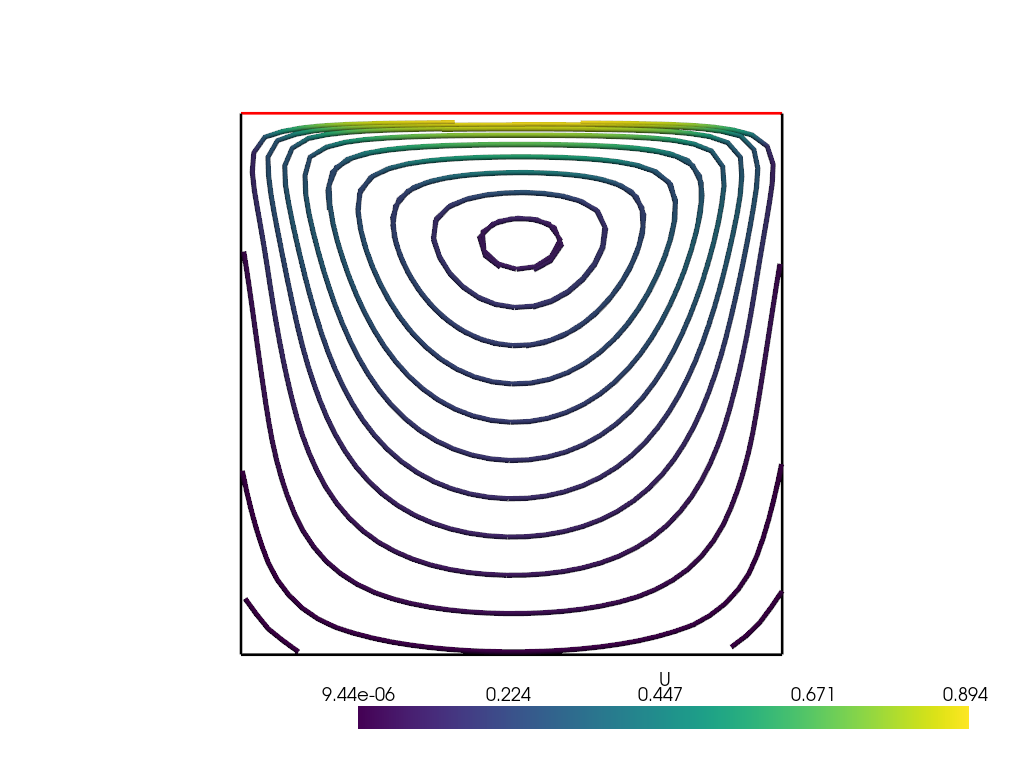

In [13]:
plotter = pyvista.Plotter()
plotter.add_mesh(slice_boundaries["movingWall"], color='red', line_width=3)
plotter.add_mesh(slice_boundaries["fixedWalls"], color='black', line_width=3)
plotter.add_mesh(streamlines.tube(radius=0.0005), scalars="U")
plotter.view_xy()
plotter.enable_parallel_projection()
plotter.show()

In [14]:
print(internal_mesh.point_data.keys())  # Lists available point-based fields
print(internal_mesh.cell_data.keys())   # Lists available cell-based fields


['U', 'p']
['U', 'p']


In [15]:
cell_data = internal_mesh.cell_data["U"]  # Example for cell_data
cell_data

pyvista_ndarray([[ 2.53494e-04, -2.50378e-04,  0.00000e+00],
                 [ 1.41338e-04,  1.11475e-04,  0.00000e+00],
                 [-1.17699e-03,  5.64654e-04,  0.00000e+00],
                 ...,
                 [ 5.83952e-01, -7.26601e-02,  0.00000e+00],
                 [ 4.15827e-01, -1.27868e-01,  0.00000e+00],
                 [ 3.08819e-01, -1.49468e-01,  0.00000e+00]],
                shape=(400, 3), dtype=float32)

In [16]:
print(internal_mesh.cells_dict.keys())


dict_keys([np.uint8(12)])


In [ ]:
from dolfinx import mesh as dmesh
import numpy as np
from mpi4py import MPI

# Extract points and connectivity
points = internal_mesh.points
cells = internal_mesh.cells_dict  # Dictionary mapping cell type to connectivity

# Assume tetrahedral mesh (modify based on actual mesh type)
tet_cells = cells.get(12)  # 12 corresponds to VTK_HEXAHEDRON
if tet_cells is None:
    raise ValueError("No hexahedron cells found in the mesh.")

import ufl
# Define mesh element
shape = "hexahedron"
degree = 1
cell = ufl.Cell(shape)

import basix
v_cg = basix.ufl.element(
    "Lagrange", cell.cellname(), 1, shape=(3,)
)
mesh_ufl = ufl.Mesh(v_cg)


In [18]:
print(tet_cells.shape)

(400, 8)


In [ ]:
# Create Dolfinx Mesh
domain = dmesh.create_mesh(MPI.COMM_WORLD, tet_cells, points, mesh_ufl)
